# NLP DEAP Project

# 0. Objectives

### PoC 1: Link skills obtained from education programs to skills needed in the labor market to identify skill gaps per sector/job

- In order to do so, we scraped online data from different universities across Belgium. We retrieved an exhaustive list of education programs each of them had to offer, alongside the courses within each program and a description of each course. On the other hand, we retrieved the esco dataset which contains a large list of 13000 skills with a skill description attached. Each of these skills are linked to a list of professions/occupations in a graph database manner. 
- By using the course descriptions and the skill descriptions at hand, we can calculate the similarity between each combination of these two lists of text. In order to do this, we must first "vectorize" these strings, namely obtain their numerical representation/translation. There exists many methods to this day to do so (Bag of words, TF-IDF), although we will be using a pre-trained Word2Vec model (Google news vector). The google news vectors provided by Google were obtained via a deep neural net trained on millions of texts (Billions of words), namely they allow to capture to some extent the proximity between two words that do not share a stem. How could you explain that the words "dog" and "cat" are somewhat similar as they both refer to common household pets? This is covered by the pre-trained Word2Vec model we are using, integrating "word embeddings" that take into account words and sentences that have nothing in common at first view but share similar meanings or context. The "vectorization" of the strings is then done using the pre-trained word2vec model as a reference (like a dictionary for the spatial representation of each word) and we obtain vectors in a 300-dimension space. We take the mean of each words' representation in that space as a proxy for the whole text. 
- Once this "translation" is provided for all our course and skill descriptions we are able to compute the cosine similarity between the vectors that represent them and thus obtain a number between 0 and 1 representing how close in meaning/context each strings are. We consider a threshold of 0.78, meaning that we do not associate skills to courses if they fall under that limit. If they do, we retrieve the score for each match as well as the text considered. 
- By proceeding this way, we've associated a list of skills that are most relevant and attached them to each course. Given that we already have the links between the same skill database and occupation, we've thus established the indirect link between courses and occupation. By grouping courses by education program and university, we thus have the link between education programs and occupation and can effectively identify skill gaps. The best suited tool to identify these gaps was considered to be a graph. The contruction of an interactive graph allowing to explore all the links established in this notebook are provided in the R scripts attached to this project.

    This notebook contains only the pre-processing, vectorization, cosine similarity computations and recording in new dataframes of our University and skill datasets.

# 1. The code

## 1.1 Loading packages and data

#### The packages

In [ ]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from collections import Counter
from itertools import chain
import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk, string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim import corpora
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

import spacy

import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings('ignore')

from gensim.similarities import docsim
#from DocSim import DocSim

import time

C:\Users\laksa\Documents\anaconda_3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\laksa\Documents\anaconda_3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### The data 

Use the read_clean_data function to get rid of any NA's from the data you want to match. The results of this first hand cleaning will be stored in a new column called "Clean_strings".

As the data that was scraped came in differeny formats, sometimes with complementary information to the course descriptions you may combine them in a same column for matching afterwards! Just specify them in a list and attribute them to the input "other_columns"

In [2]:
def read_clean_data(path,column_name,other_columns = None):
    
    data = pd.read_csv(str(path), encoding = "ISO-8859-1")

    
    if other_columns:
        data['Extended'] = data[str(column_name)]
        for col in other_columns:
            data['Extended'] = data['Extended'] + data[str(col)].map(str)
    
    # Reads the data in the path you specified, drops na's and resets the index to avoid concatenation failures afterwards
    data.dropna(subset=[column_name],inplace = True)
    data.reset_index(drop = True, inplace = True)
    
    # Takes care of decoding all characters to avoid miss-steps in the datacleaning process!
    for i in range(0,len(data)):
        if other_columns:
            temp1 = data.loc[i,'Extended']
            temp2 = unidecode.unidecode(str(temp1))
            data.loc[i,"Clean_strings"] = temp2
        else:
            temp1 = data.loc[i,str(column_name)]
            temp2 = unidecode.unidecode(str(temp1))
            data.loc[i,"Clean_strings"] = temp2
        
    return data

In [3]:
malta = read_clean_data(path = "Scraped Universities/Courses_UMalta.csv",
                        column_name = 'courseDescription',
                       other_columns = ['courseDepartment'])
skills = read_clean_data(path = "Scraped Universities/skills_en.csv",
                        column_name = 'description')

## 1.2 Tokenizing & Pre-processing

#### This section is mainly to reverse engineer the pre-processing we apply to our data. If you want to head directly to matching your two dataframes go to section 1.3!

 We use four pre-processing steps: 
    - Stopwords (remove unmeaningful words)
    - Punctuations (remove special characters to avoid confusions)
    - Lowercase (get rid of uppercase to avoid missing similar words)
    - Lemmatization (Keep only the lemma of each word to reduce distance between words which are the same but have a conjugation or are constructed differently given the sentence in which it is used)

In [5]:
stopW = stopwords.words('english')
stopW += ["msc","also",'teaching','class','student',"classroom","teach"]
special_characters = [",","?",".",";","/",":","+","=","~","%","´",
                      "`","¨","^","*","$",'&',"|","@",'"',"£",
                      "'","(",")","§","!","{","}","-","_","²","[",
                      ">","<","]"]

transformation_sc_dict = {initial :" " for initial in special_characters}
lemmatizer = WordNetLemmatizer()

def preprocessing(text):
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Deleting words with only one character
    tokens = [token for token in tokens if len(token)>2]
    
    # Stopwords + Lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stopW]
    
    # Deleting specific characters
    tokens = [token.translate(str.maketrans(transformation_sc_dict)) for token in tokens]
    
    # Lemmatization (optional)
    tokens = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(token, pos = 'a'),pos = 'v'),pos='n') for token in tokens]
    
    return tokens

#### Visaulization tool to reverse engineer pre-processing:

In [9]:
def plot_frequent_words(list_of_words):
    dist = nltk.FreqDist(list_of_words)
    X = [nb[1] for nb in dist.most_common(40)]
    y = [nb[0] for nb in dist.most_common(40)]
    ax = sns.barplot(X,y)
    ax.set(xlabel = 'Word Frequencies', ylabel = 'Words', title = 'Most common words in the corpus')
    plt.show()

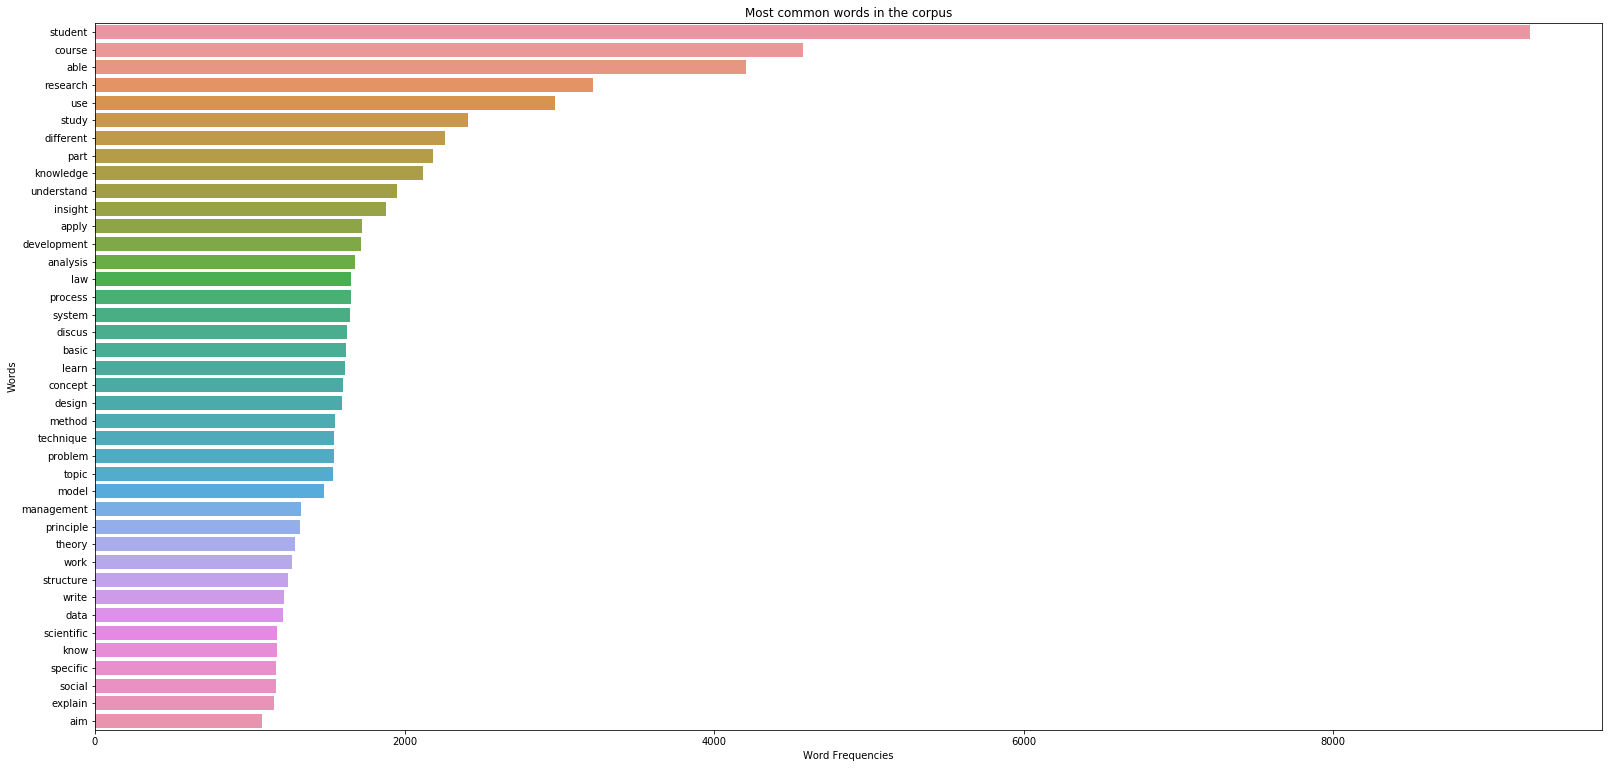

415974


In [10]:
plt.figure(figsize=(27,13))

# Just to try it out, apply the pre processing function to the program descriptions.
data['tokens'] = data["Extended"].apply(preprocessing)

ep_words = data.tokens.tolist()
ep_words2 = [[text.strip() for text in descr] for descr in ep_words]
clean_words_ep = [[word for word in words if word != ''] for words in ep_words2]
data['clean_tokens'] = clean_words_ep

ep_full_words = []
for descr in clean_words_ep:
    for word in descr:
        ep_full_words.append(word)
        
plot_frequent_words(ep_full_words)
print(len(ep_full_words))

Additionnal analytics were done on our data, including T-SNE, PCA and LDA Model representation of our data. We won't add them hear to avoid clogging the notebook as they only constitute tools to help us visualize what our data represents.

# 1.3 NLP Automatic matching 1.0 (better 2.0 version in section 1.4 below)

## Please check out section 1.4 which is an optimized and facilitated version of our NLP matching

Now that the pre-processing has been established and optimized, we can confidently go on to vectorize our strings taking these arranged pre-processing steps into account

#### loading google word embeddings

As we mentionned in the abstract above, we use Google's pre-trained word2vec model which provides word embeddings. 

In [22]:
wv_from_bin = KeyedVectors.load_word2vec_format(r'C:\Users\laksa\Documents\DEAP\NLP AI\GoogleNews-vectors-negative300.bin', binary = True)

#### Defining the algorithm for cosine similarity using Word2Vec

What we've done here is create a class that will take any two strings, apply the pre-processing we've defined above, vectorize using the pre-trained word2vec model, compute the cosine similarity between the two vectors obtained and record them only if the score was above a threshold to be defined (we chose 0.78)

In [7]:
punctuation_map = dict((ord(char), None) for char in string.punctuation)
class DocSimV1(object):
    def __init__(self, w2v_model , stopwords=stopW , remove_punctuation_map=punctuation_map):
        self.w2v_model = w2v_model
        self.stopwords = stopwords
        self.remove_punctuation_map = punctuation_map

    def vectorize(self, doc):
        """Identify the vector values for each word in the given document"""
        doc = doc.lower()
        words = [w.translate(punctuation_map) for w in doc.split(" ") if w not in self.stopwords]
        word_vecs = []
        for word in words:
            try:
                vec = self.w2v_model[word]
                word_vecs.append(vec)
            except KeyError:
                # Ignore if the word doesn't exist in the vocabulary
                pass

        # Assuming that document vector is the mean of all the word vectors
        vector = np.mean(word_vecs, axis=0)
        return vector


    def _cosine_sim(self, vecA, vecB):
        """Find the cosine similarity distance between two vectors."""
        csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
        if np.isnan(np.sum(csim)):
            return 0
        return csim

    def calculate_similarity(self, source_doc, target_docs=[], threshold=0):
        """Calculates & returns similarity scores between given source document & all
        the target documents."""
        if isinstance(target_docs, str):
            target_docs = [target_docs]

        source_vec = self.vectorize(source_doc)
        results = []
        for doc in target_docs:
            target_vec = self.vectorize(doc)
            sim_score = self._cosine_sim(source_vec, target_vec)
            if sim_score > threshold:
                results.append({
                    'score' : sim_score,
                    'doc' : doc
                })
            # Sort results by score in desc order
            results.sort(key=lambda k : k['score'] , reverse=True)

        return results

#### Calculating cosine similarity between esco skills and course content

We can then apply it to any two strings as mentionned above, to verify what the algorithm yields we test it on an example from our data:

In [30]:
ds = DocSim(wv_from_bin)

source_doc = data['Course_content'][0]
target_docs = [skills_list[0],skills_list[1],skills_list[2]]

# This will return 3 target docs with similarity score
sim_scores = ds.calculate_similarity(source_doc, target_docs)
print(sim_scores)


[{'score': 0.600234, 'doc': 'Identify oppression in societies, economies, cultures, and groups, acting as a professional in an non-oppressive way, enabling service users to take action to improve their lives and enabling citizens to change their environment in accordance with their own interests.'}, {'score': 0.44881448, 'doc': 'Assign and manage staff tasks in areas such as scoring, arranging, copying music and vocal coaching.'}, {'score': 0.35091925, 'doc': "Supervise the operations of a correctional facility or other correctional procedures, ensuring that they are compliant with legal regulations, and ensure that the staff complies with regulations, and aim to improve the facility's efficiency and safety."}]


Notice here that we haven't assigned a threshold so any score is considered. 

#### Applying the algo to our data

We start by passing all the skill descriptions in ESCO to a list and initializing a void list that will be filled by the matching between each course description and every skill description that passes the threshold of 0.78 in the same fashion as the example above.

In [195]:
skills_list = skills_full['description'].tolist()
ep_skills = []
import time

start = time.time()
for i in range(0,len(data)):
    ep_skills.append(ds.calculate_similarity(data['Extended'][i],skills_list,threshold = 0.78))
end = time.time()
print(end-start)

11550.786283254623


In [ ]:
start = time.time()
end = time.time()
print(end-start)

### Creating a dataframe for our results 

Now that all the matches have been made, we create a void dataframe to be filled by a row for every unique association between a course descrition and a skill description. We also complement this link with info retrieved from the two original datasets to complement our graph

In [196]:
test = pd.DataFrame(columns=['Country','University','Program','Courses','Syllabus','Description of the program','skill','skill_description','skill_uri_esco'])
l = 0
for j in range(0,len(ep_skills)):
    for i in range(0,len(ep_skills[j])):
        temp1 = skills_full[skills_full['description'] == (ep_skills[j][i]['doc'])].preferredLabel.item()
        temp2 = skills_full[skills_full['preferredLabel'] == (temp1)].description.item()
        temp3 = skills_full[skills_full['preferredLabel'] == (temp1)].conceptUri.item()
        test.loc[l,['Country','University','Program','Courses','Syllabus']] = data.loc[j,['Country','University','Program','Courses','Extended']]
        test.loc[l,['Description of the program']] = np.nan
        test.loc[l,['skill']] = temp1
        test.loc[l,['skill_description']] = temp2
        test.loc[l,['skill_uri_esco']] = temp3
        l += 1

#### End result 

In [202]:
test.tail()

,Country,University,Program,Courses,Syllabus,Description of the program,skill,skill_description,skill_uri_esco
32751,Belgium,University of Antwerp,Master of Maritime and Air Transport Management,Transport Modelling,4 step models Aggregate-Disaggregate-Aggregat...,NaN,develop energy saving concepts,Use current research results and collaborate w...,http://data.europa.eu/esco/skill/0037c821-2898...
32752,Belgium,University of Antwerp,Master of Maritime and Air Transport Management,Welfare Economics,The course is devided into six parts: 1. Intro...,NaN,socio-economic trends in your sector,Situation and evolution of a sector from a soc...,http://data.europa.eu/esco/skill/463023d0-cc10...
32753,Belgium,University of Antwerp,Master of Maritime and Air Transport Management,Welfare Economics,The course is devided into six parts: 1. Intro...,NaN,keep up with current trends in psychotherapy,Keep up with current trends and debates in men...,http://data.europa.eu/esco/skill/dc4b2c95-d807...
32754,Belgium,University of Antwerp,Master of Maritime and Air Transport Management,Welfare Economics,The course is devided into six parts: 1. Intro...,NaN,carry out social work research,Initiate and design research to assess social ...,http://data.europa.eu/esco/skill/ceeb2e10-f354...
32755,Belgium,University of Antwerp,Master of Maritime and Air Transport Management,Project Methodology,- Project Management environment - Project Man...,NaN,collaborate with a technical staff in artistic...,Coordinate your artistic activities with other...,http://data.europa.eu/esco/skill/94d02529-72e1...


In [92]:
test.head()

,Country,University,Program,Courses,Syllabus,Description of the program,skill,skill_description,skill_uri_esco
0,Belgium,VUB,Master of Philosophy and Moral Sciences: Ethic...,Introduction to feminist thought,This course unit aims to give students a criti...,NaN,gender studies,Interdisciplinary academic field which studies...,http://data.europa.eu/esco/skill/e24377fb-020b...
1,Belgium,VUB,Master of Philosophy and Moral Sciences: Ethic...,Introduction to feminist thought,This course unit aims to give students a criti...,NaN,teach sociology,Instruct students in the theory and practice o...,http://data.europa.eu/esco/skill/a222fb51-a43f...
2,Belgium,VUB,Master of Philosophy and Moral Sciences: Philo...,Introduction to feminist thought,This course unit aims to give students a criti...,NaN,gender studies,Interdisciplinary academic field which studies...,http://data.europa.eu/esco/skill/e24377fb-020b...
3,Belgium,VUB,Master of Philosophy and Moral Sciences: Philo...,Introduction to feminist thought,This course unit aims to give students a criti...,NaN,teach sociology,Instruct students in the theory and practice o...,http://data.europa.eu/esco/skill/a222fb51-a43f...
4,Belgium,VUB,Research Master of Philosophy: Standaard traject,Introduction to feminist thought,This course unit aims to give students a criti...,NaN,gender studies,Interdisciplinary academic field which studies...,http://data.europa.eu/esco/skill/e24377fb-020b...


#### Writing to CSV  

In [203]:
test.to_csv('UAntwerpen_skills.csv')

#### Additional cleaning

Some encoding problems can be hard to spot, here is a code to fix that issue in case it is found in some of the data.

In [219]:
ulie = pd.read_csv('University Skills/UCL_skills.csv', index_col = 0)

In [220]:
import unidecode
ulie['Program'] = ulie['Program'].astype(str)

for i in range(0,len(ulie)):
    temp1 = ulie.loc[i,'Program']
    temp2 = unidecode.unidecode(str(temp1))
    ulie.loc[i,'Program'] = temp2
    

In [221]:
ulie.head()

,Country,University,Program,Courses,Syllabus,Description of the program,skill,skill_description,skill_uri_esco
0,Belgium,UCL,Master [120] in European Studies,European Competition Law,· Introduction. Why do we protect comp...,NaN,ensure compliance with gaming laws,Ensure full compliance within the requirements...,http://data.europa.eu/esco/skill/c9b40bd1-39e2...
1,Belgium,UCL,Master [120] in European Studies,European Competition Law,· Introduction. Why do we protect comp...,NaN,common aviation safety regulations,The body of legislation and regulations that a...,http://data.europa.eu/esco/skill/d5b63f98-28ce...
2,Belgium,UCL,Master [120] in Law,European Competition Law,· Introduction. Why do we protect comp...,NaN,ensure compliance with gaming laws,Ensure full compliance within the requirements...,http://data.europa.eu/esco/skill/c9b40bd1-39e2...
3,Belgium,UCL,Master [120] in Law,European Competition Law,· Introduction. Why do we protect comp...,NaN,common aviation safety regulations,The body of legislation and regulations that a...,http://data.europa.eu/esco/skill/d5b63f98-28ce...
4,Belgium,UCL,Specialised master in European law,European Competition Law,· Introduction. Why do we protect comp...,NaN,ensure compliance with gaming laws,Ensure full compliance within the requirements...,http://data.europa.eu/esco/skill/c9b40bd1-39e2...


In [ ]:
ulie.to_csv

# 1.4 NLP automatic matching v.2.0.0 

#### This is a much improved version of the automatic NLP matching, each text is only vectorized once here and is made extremely simple for the user. All you need to do is specify which dataframes you want to match, what the names of the columns containing the text which is to be matches and the minimum cosine similarity to consider a Match to be recorded. 

In [12]:
punctuation_map = dict((ord(char), None) for char in string.punctuation)
class DocSimV2(object):
    def __init__(self, w2v_model , stopwords=stopW , remove_punctuation_map=punctuation_map):
        self.w2v_model = w2v_model
        self.stopwords = stopwords
        self.remove_punctuation_map = punctuation_map

    def vectorizer(self, doc):
        """Identify the vector values for each word in the given document"""
        doc = doc.lower()
        words = [w.translate(punctuation_map) for w in doc.split(" ") if w not in stopW]
        word_vecs = []
        for word in words:
            try:
                vec = wv_from_bin[word]
                word_vecs.append(vec)
            except KeyError:
                # Ignore if the word doesn't exist in the vocabulary
                pass

        # Assuming that document vector is the mean of all the word vectors
        vector = np.mean(word_vecs, axis=0)
        return vector


    def _cosine_sim(self, vecA, vecB):
        """Find the cosine similarity distance between two vectors."""
        csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
        if np.isnan(np.sum(csim)):
            return 0
        return csim
        
    def calculate_similarity(self, datasetA, text_datasetA, datasetB, text_datasetB, threshold=0):
        """Calculates & returns similarity scores between given source document & all
        the target documents."""
        datasetA.reset_index(inplace = True,drop = True)
        datasetB.reset_index(inplace = True,drop = True)
        datasetA["vectors"] = datasetA[str(text_datasetA)].apply(self.vectorizer)
        datasetB["vectors"] = datasetB[str(text_datasetB)].apply(self.vectorizer)
        
        
        #colsA = list(datasetA.columns.values)
        #colsB = list(datasetB.columns.values)
        #cols = [colsA,colsB]
        #flat_cols = [item for sublist in cols for item in sublist]
        #flat_cols.append("similarity")
        #result = pd.DataFrame(columns = flat_cols)
        #l = 0
        ind_A = []
        ind_B = []

        for i in range(0,len(datasetA)):
            vecA = datasetA.loc[i,"vectors"]
            for j in range(0,len(datasetB)):
                vecB = datasetB.loc[j,"vectors"]
                sim_score = self._cosine_sim(vecA,vecB)
                
                if sim_score > threshold:
                    ind_A.append(i)
                    ind_B.append(j)
                    
        matchesA = datasetA.loc[ind_A,:].drop(datasetA.columns[[0,1]],axis = 1)
        #matchesA = matchesA.set_index(pd.Index(range(0,len(matchesA))))#.drop(['level_0','index'], axis=1, inplace=True)#.reset_index(inplace = True, drop = True)
        matchesB = datasetB.loc[ind_B,:].drop(datasetB.columns[[0,1]],axis = 1)#.reset_index(inplace = True, drop = True)
        full_data = pd.concat([matchesA.reset_index(drop = True),matchesB.reset_index(drop = True)], axis=1)            
                    #result.loc[l,"similarity"] = sim_score
                    #result.loc[l,colsA] = datasetA.loc[i,colsB]
                    #result.loc[l,colsB] = datasetB.loc[j,colsB]
                    #l += 1
                     
                    
        return full_data

2057.8831470012665


In [ ]:
start = time.time()
ds = DocSimV2(wv_from_bin)
results = ds.calculate_similarity(datasetA = malta,
                                  text_datasetA = "Clean_strings",
                                  datasetB = skills,
                                  text_datasetB = "Clean_strings",
                                  threshold = 0.78)
end = time.time()
print(end-start)

In [16]:
results.to_csv('University Skills/UMalta_skills.csv', encoding = 'utf-8')

# 1.5 NLP automatic matching v.3.0.0 

Below is the last version of our string matching program which provides a complete walkthrough. The onyl input needed from the user is the directory to the data he wishes to match and a trained word2vec model.

In [23]:
# Load Word2Vec model:
#wv_from_bin = KeyedVectors.load_word2vec_format(r'C:\Users\laksa\Documents\DEAP\NLP AI\GoogleNews-vectors-negative300.bin', binary = True)

lemmatizer = WordNetLemmatizer()    
    
#Pre-processing:
punctuation_map = dict((ord(char), None) for char in string.punctuation)
#stop_words = set(stopwords.words("english"))
#stopW = []
#for element in stop_words:
#    stopW.append(element)
stopW = stopwords.words('english')
stopW += ["msc","also",'teaching','class','student',"classroom","teach",'learn']
special_characters = [",","?",".",";","/",":","+","=","~","%","´",
                      "`","¨","^","*","$",'&',"|","@",'"',"£",
                      "'","(",")","§","!","{","}","-","_","²","[",
                      ">","<","]"]

class DocSimV3(object):
    
    def __init__(self, w2v_model , stopwords=stopW , remove_punctuation_map=punctuation_map):
        self.w2v_model = w2v_model
        self.stopwords = stopwords
        self.remove_punctuation_map = punctuation_map
    
    def read_clean_data(self,path_A,path_B):
        """Cleaning, wrangling automated on the two datasets you consider for matching"""

        for path in [path_A,path_B]:
            
            if path == path_A:
                print("These are the columns of the first dataset you want to match:")
            else:
                print("These are the columns of the second dataset you want to match:")
            print("\n")
            
            data = pd.read_csv(str(path), encoding = "ISO-8859-1")
            data.reset_index(drop = True, inplace = True)
            
            #######################
            #for testing purposes:
            data = data.sample(3) 
            #######################
            
            print('\n')
            for name in data.columns:
                print(name)
            print('\n')
                
            column_name = []
            other_columns = []
                
            colA = input("What's the name of the column that contains the strings you'd like to use for matching?")
            while colA not in list(data.columns):
                print("This columns doesn't exist in your data, try another one from the list printed above!")
                print('\n')
                colA = input("What's the name of the column that contains the strings you'd like to use for matching?")

            column_name.append(str(colA))
                
            while colA != "stop":
                colA = input('Are there other columns that should be used for the matching? If not type "stop"!')
                print('\n')
            
                if colA != 'stop' and colA in list(data.columns):
                    other_columns.append(str(colA))
                    print("You've already selected the following:")
                    print('\n')
                    print(column_name[0])
                    for name in other_columns:
                        print(name)
                    print('\n')
            
                elif colA == 'stop':
                    print('Moving on!')
                    print('\n')
                    break

                elif colA not in list(data.columns):
                    print("This columns doesn't exist in your data, try another one from the list printed above!")
                    print('\n')
                    continue
                    
            if other_columns != []:
                data['Extended'] = data[column_name[0]]
                for col in other_columns:
                    data['Extended'] = data['Extended'] + data[str(col)].map(str)
    
    # Reads the data in the path you specified, drops na's and resets the index to avoid concatenation failures afterwards
            data.dropna(subset=column_name,inplace = True)
            data.reset_index(drop = True, inplace = True)
            print("\n")
            print("Please wait while we process your data!")
            print("\n")
    
    # Takes care of decoding all characters to avoid miss-steps in the datacleaning process!
            for i in range(0,len(data)):
                if other_columns:
                    temp1 = data.loc[i,'Extended']
                    temp2 = unidecode.unidecode(str(temp1))
                    data.loc[i,"Clean_strings"] = temp2
                else:
                    temp1 = data.loc[i,column_name[0]]
                    temp2 = unidecode.unidecode(str(temp1))
                    data.loc[i,"Clean_strings"] = temp2
            
            if path == path_A:
                dfA = data
            else:
                dfB = data
            
        return dfA,dfB
                        
    def vectorizer(self, doc):
        """Identify the vector values for each word in the given document"""
        #stopW = stopwords
        #doc = doc.lower()
        #doc = re.sub(r'[^\w\s]','',doc)
        #words_1 = [w for w in doc.split(" ")]
        #words_2 = [word for word in words_1 if word not in stopwords.words('english')]
        doc = doc.lower()
        words = [w.translate(punctuation_map) for w in doc.split(" ") if w not in stopW]
        words = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(w, pos = 'a'),pos = 'v'),pos='n') for w in words]
    
        word_vecs = []
        for word in words:
            try:
                vec = wv_from_bin[word]
                word_vecs.append(vec)
            except KeyError:
                # Ignore if the word doesn't exist in the vocabulary
                pass

        # Assuming that document vector is the mean of all the word vectors
        vector = np.mean(word_vecs, axis=0)
        return vector


    def _cosine_sim(self, vecA, vecB):
        """Find the cosine similarity distance between two vectors."""
        csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
        if np.isnan(np.sum(csim)):
            return 0
        return csim
    
    def similarity_join(self,data):
    
        data.reset_index(inplace = True, drop = True)
        
        print("\n")
        print("The data model we considered for our graph rendering in the shiny app is as follows:","\n","\n",
             "University","\n",
             "Program","\n",
             "Course","\n",
             "Skill","\n","\n",
             "We highly recommend you select the columns in your dataset corresponding to those cited above if you want to visualize your matches in our Shinyapp.","\n",
             "Although this is entirely your decision, you may keep the ones you see as fittest.","\n",
             "If you do decide to follow our data model and wish to upload your data to our graph rendering, please specify which columns lin your data listed below correspond to the information listed above","\n")
        for name in data.columns:
            print(name)
        print('\n')
        
        cols = []
        col = input('Which columns would you like to keep?')
        print('\n')
    
        cols.append(col)
    
        while col != "stop":
            col = input('Any more columns you want to keep? If not type "stop"!')
            print('\n')
            
            if col != 'stop' and col in list(data.columns):
                cols.append(col)
            
            elif col == 'stop':
                print('You stopped the process')
                print('\n')
                data = data.loc[:,cols]
                return(data)

            elif col not in list(data.columns):
                print("This columns doesn't exist in your data, try another one from the list printed above!")
                print('\n')
                continue
                
    def graph_format(self, data):
        
        print("\n")
        start = input('Are you using our data model? If so type "Yes". If not, please type "Goodbye"')
        print("\n")
        if start == "Goodbye":
            print("K bye :'(")
            return data
        elif start == "Yes":
            print("\n","\n")
            print("University","\n",
                  "Program","\n",
                  "Course","\n",
                  "Skills")
            print("\n","\n","Please specify which columns in your data listed below correspond to those in our data model listed above.","\n","\n")
            for var in list(data.columns):
                print(var)

            univ=input("The column in your data that corresponds to 'University':")
            prog=input("The column in your data that corresponds to 'Program':")
            crse=input("The column in your data that corresponds to 'Course':")
            skil=input("The column in your data that corresponds to 'Skills':")
            print("\n","\n")
            
            data.rename(
                inplace = True,
                columns = 
                            {
                    str(univ):"University",
                    str(prog):"Program",
                    str(crse):"Course",
                    str(skil):"Skills"
                            }
                           )
                
            return data
        
    def calculate_similarity(self, path_A, path_B, threshold=0):
        """Calculates & returns similarity scores between given source document & all
        the target documents."""
        
        datasetA, datasetB = self.read_clean_data(path_A, path_B)
        print("\n")
        print("We cleaned your data!")
        print("\n")
        print("Please wait while we figure out the matches!")
        print("\n")
        
        #if datasetA["Clean_strings"] and datasetB["Clean_strings"]:
            
        datasetA.reset_index(inplace = True,drop = True)
        datasetB.reset_index(inplace = True,drop = True)
        datasetA["vectors"] = datasetA[str("Clean_strings")].apply(self.vectorizer)
        datasetB["vectors"] = datasetB[str("Clean_strings")].apply(self.vectorizer)
        
        #else:
        #    datasetA.reset_index(inplace = True,drop = True)
        #    datasetB.reset_index(inplace = True,drop = True)
        #    datasetA["vectors"] = datasetA[str(text_datasetA)].apply(self.vectorizer)
        #    datasetB["vectors"] = datasetB[str(text_datasetB)].apply(self.vectorizer)
        
        #colsA = list(datasetA.columns.values)
        #colsB = list(datasetB.columns.values)
        #cols = [colsA,colsB]
        #flat_cols = [item for sublist in cols for item in sublist]
        #flat_cols.append("similarity")
        #result = pd.DataFrame(columns = flat_cols)
        #l = 0
        ind_A = []
        ind_B = []
        score_record = []

        for i in range(0,len(datasetA)):
            vecA = datasetA.loc[i,"vectors"]
            for j in range(0,len(datasetB)):
                vecB = datasetB.loc[j,"vectors"]
                sim_score = self._cosine_sim(vecA,vecB)
                
                if sim_score > threshold:
                    ind_A.append(i)
                    ind_B.append(j)
                    score_record.append(sim_score)
                    
        matchesA = datasetA.loc[ind_A,:].drop(datasetA.columns[[0]],axis = 1)
        #matchesA = matchesA.set_index(pd.Index(range(0,len(matchesA))))#.drop(['level_0','index'], axis=1, inplace=True)#.reset_index(inplace = True, drop = True)
        matchesB = datasetB.loc[ind_B,:].drop(datasetB.columns[[0]],axis = 1)#.reset_index(inplace = True, drop = True)
        full_data = pd.concat([matchesA.reset_index(drop = True),matchesB.reset_index(drop = True)], axis=1)       
        full_data['Cosine_similarity'] = score_record
                    #result.loc[l,"similarity"] = sim_score
                    #result.loc[l,colsA] = datasetA.loc[i,colsB]
                    #result.loc[l,colsB] = datasetB.loc[j,colsB]
                    #l += 1
        print("\n","\n")
        print("We have your matches! Let's do some cleaning to tidy the results!")
        print("\n","\n")
        
        """Some additionnal cleaning for the end result"""
        intermediate = self.similarity_join(full_data)   
        
        """Recommended column names for easy grpah formatting afterwards"""
        final = self.graph_format(intermediate)            
        
        print("\n","\n")
        print("We're all set, go visualize that data!")
        print("\n","\n")
        
        return final

In [26]:
start = time.time()

# Load the word2bec model of your preferrence 
ds = DocSimV3(wv_from_bin)

results = ds.calculate_similarity(path_A = "Scraped Universities/Courses_ULatvia_all.csv",
                                  path_B = "Scraped Universities/skills_en.csv",
                                  threshold = 0)
end = time.time()
print(end-start)

These are the columns of the first dataset you want to match:




Course_code
program
Course_name
Course_content
Course_master




What's the name of the column that contains the strings you'd like to use for matching? Course_name
Are there other columns that should be used for the matching? If not type "stop"! Course_content




You've already selected the following:


Course_name
Course_content




Are there other columns that should be used for the matching? If not type "stop"! stop




Moving on!




Please wait while we process your data!


These are the columns of the second dataset you want to match:




conceptType
conceptUri
skillType
reuseLevel
preferredLabel
altLabels
description




What's the name of the column that contains the strings you'd like to use for matching? description
Are there other columns that should be used for the matching? If not type "stop"! preferredLabel




You've already selected the following:


description
preferredLabel




Are there other columns that should be used for the matching? If not type "stop"! stop




Moving on!




Please wait while we process your data!




We cleaned your data!


Please wait while we figure out the matches!



 

We have your matches! Let's do some cleaning to tidy the results!

 



The data model we considered for our graph rendering in the shiny app is as follows: 
 
 University 
 Program 
 Course 
 Skill 
 
 We highly recommend you select the columns in your dataset corresponding to those cited above if you want to visualize your matches in our Shinyapp. 
 Although this is entirely your decision, you may keep the ones you see as fittest. 
 If you do decide to follow our data model and wish to upload your data to our graph rendering, please specify which columns lin your data listed below correspond to the information listed above 

program
Course_name
Course_content
Course_master
Extended
Clean_strings
vectors
conceptUri
skillType
reuseLevel
preferredLabel
altLabels
description
Extended
Clean_strings
vectors
Cosine_similarity




Which columns would you like to keep? program


Any more columns you want to keep? If not type "stop"! 




This columns doesn't exist in your data, try another one from the list printed above!




Any more columns you want to keep? If not type "stop"! Course_name


Any more columns you want to keep? If not type "stop"! preferredLabel


Any more columns you want to keep? If not type "stop"! Cosine_similarity


Any more columns you want to keep? If not type "stop"! stop




You stopped the process






Are you using our data model? If so type "Yes". If not, please type "Goodbye" Goodbye




K bye :'(

 

We're all set, go visualize that data!

 

52.465248823165894


In [ ]:
start = time.time()
ds = DocSimV3(wv_from_bin)
results = ds.calculate_similarity(path_A = "Scraped Universities/Courses_UMalta.csv",
                                  path_B = "Scraped Universities/skills_en.csv",
                                  threshold = 0)
end = time.time()
print(end-start)

In [38]:
results.head()

,University,Program,Course,Skills
0,The Univeristy of Malta,Master of Arts in Spirituality (M.A. Spirit.(M...,Spirituality and Life Stages,neuropathology
1,The Univeristy of Malta,Master of Arts in Spirituality (M.A. Spirit.(M...,Spirituality and Life Stages,transfer viscous soap
2,The Univeristy of Malta,Master of Arts in Spirituality (M.A. Spirit.(M...,Spirituality and Life Stages,archaeobotany
3,The Univeristy of Malta,Master of Arts in Media and Communications (M....,"Film, Technology and the Literary Canon",neuropathology
4,The Univeristy of Malta,Master of Arts in Media and Communications (M....,"Film, Technology and the Literary Canon",transfer viscous soap
